# Load data

In [ ]:
from google.colab import drive
import os
import numpy as np
import imageio.v2 as imageio
from tqdm import tqdm
import scipy

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define path to the 'bear' folder (edit if your path is different)
bear_root = '/content/drive/MyDrive/Bear'

# Load calibration data
calib_file = os.path.join(bear_root, "Calib_Results.mat")
calib_data = scipy.io.loadmat(calib_file)
KK = calib_data["KK"]  # 3x3 intrinsic matrix
extrinsics = {f"view_{i:02d}": (calib_data[f"Rc_{i}"], calib_data[f"Tc_{i}"].ravel()) for i in range(1, 21)}



# Step 3: Prepare to load views
views = sorted([d for d in os.listdir(bear_root) if d.startswith("view")])
view_data = {}

# Step 4: Load light directions and images per view
for view in tqdm(views, desc="Loading views"):
    view_path = os.path.join(bear_root, view)
    light_path = os.path.join(view_path, "light_directions.txt")
    images_path = os.path.join(view_path)

    # Load light directions (96, 3)
    light_dirs = np.loadtxt(light_path)

    # Load images (assumed .png grayscale)
    img_files = sorted([f for f in os.listdir(images_path) if f.endswith(".png")])
    imgs = [imageio.imread(os.path.join(images_path, f)) for f in img_files[:96]]
    imgs = np.stack(imgs, axis=0)  # shape: (96, H, W)
    mask = imageio.imread(os.path.join(images_path, 'mask.png'))

    # Store in dictionary
    view_data[view] = {
        "light_directions": light_dirs,
        "images": imgs,
        "mask": mask
    }

print(f"✅ Loaded {len(view_data)} views from Google Drive.")
print(f"Example: data['view_01']['images'].shape = {view_data['view_01']['images'].shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading views: 100%|██████████| 20/20 [00:51<00:00,  2.56s/it]

✅ Loaded 20 views from Google Drive.
Example: data['view_01']['images'].shape = (96, 512, 612, 3)




# Access structure

In [ ]:
# Read one view
view_01 = view_data["view_01"]
images, lights = view_01["images"], view_01["light_directions"]
print(images.shape)
print(lights.shape)
images = np.array(images).transpose(1, 2, 3, 0)
lights = np.array(lights)
print(images.shape)
print(lights.shape)
mask = view_01["mask"]
mask = (mask > 0).astype(np.uint8)


(96, 512, 612, 3)
(96, 3)
(512, 612, 3, 96)
(96, 3)


(512, 612, 3)


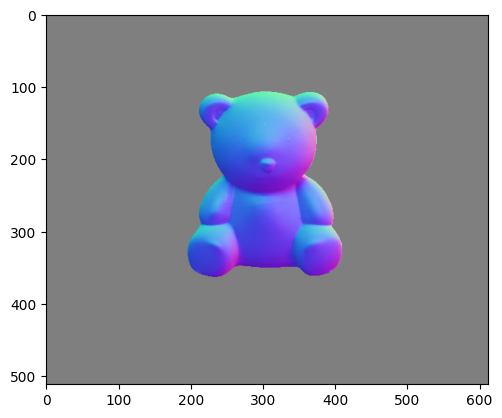

In [ ]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt



# Estimate surface normals using photometric stereo
def photometric_stereo(images, lights, mask=None):
    h, w, n = images.shape
    images_reshaped = images.reshape(-1, n)

    if mask is not None:
        mask_flat = mask.flatten()
    else:
        mask_flat = np.ones(h * w, dtype=bool)

    normals = np.zeros((h * w, 3), dtype=np.float32)

    for i in range(h * w):
        if not mask_flat[i]:
            continue
        I = images_reshaped[i, :]
        g, _, _, _ = np.linalg.lstsq(lights, I, rcond=None)
        n = g / (np.linalg.norm(g) + 1e-6)
        normals[i] = n

    normals = normals.reshape(h, w, 3)
    return normals

# Visualize normals as RGB
def visualize_normals(normals):
    normals_vis = (normals + 1) / 2  # Map from [-1, 1] to [0, 1]
    normals_vis = (normals_vis * 255).astype(np.uint8)
    return normals_vis

normals_g = photometric_stereo(images[:,:,1,:], lights, mask=mask)
normals_r = photometric_stereo(images[:,:,0,:], lights, mask=mask)
normals_b = photometric_stereo(images[:,:,2,:], lights, mask=mask)
normals = ( normals_b + normals_g + normals_r) / 3
normal_map = visualize_normals(normals)

cv2.imwrite(f'normal_map.png', normal_map)
plt.imshow(normal_map)
print(normals.shape)

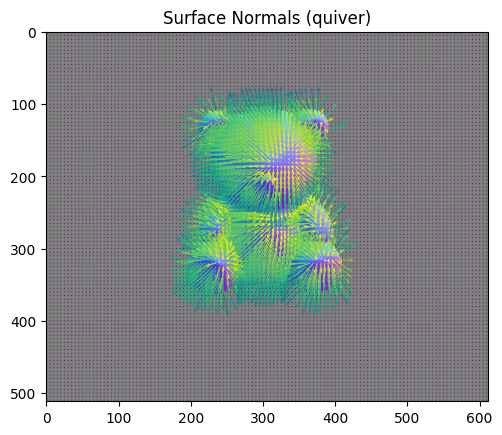

In [ ]:
step = 5
H , W = normal_map.shape[:2]
Y, X = np.mgrid[0:H:step, 0:W:step]
U = normals[::step, ::step, 0]
V = normals[::step, ::step, 1]
W = normals[::step, ::step, 2]
 # Flip y for display

plt.imshow(normal_map, cmap='gray')
plt.quiver(X, Y, U, V, W,  color='red')
plt.title("Surface Normals (quiver)")
plt.show()

In [ ]:
from numpy.fft import fft2, ifft2
def integrate_normals(normals, mask=None):
    h, w = normals.shape[:2]
    nx = normals[..., 0]
    ny = normals[..., 1]
    nz = normals[..., 2]

    # Avoid division by zero
    nz[nz == 0] = 1e-5

    # Gradient of height map
    p = nx / nz
    q = -ny / nz

    # Mask (optional)
    if mask is not None:
        p = p * mask
        q = q * mask

    # FFT coordinates
    u = np.fft.fftfreq(w).reshape(1, -1)  # (1, w)
    v = np.fft.fftfreq(h).reshape(-1, 1)  # (h, 1)
    U, V = np.meshgrid(u, v)

    # Fourier transform of gradients
    P = fft2(p)
    Q = fft2(q)

    denom = (2j * np.pi * U)**2 + (2j * np.pi * V)**2
    denom[denom == 0] = 1e-5  # Avoid division by zero

    Z = (-2j * np.pi * U * P - 2j * np.pi * V * Q) / denom
    z = np.real(ifft2(Z))

    return z

In [ ]:
depth_map = integrate_normals(normals, mask=mask)
import plotly.graph_objects as go

def plot_interactive_depth(depth_map, mask):
    Y, X = np.mgrid[0:depth_map.shape[1], 0:depth_map.shape[0]]
    Z = np.where(mask, depth_map, np.nan)

    fig = go.Figure(data=[go.Surface(
        z=-Z,
        x=X  ,
        y=Y,
        colorscale='Viridis',
        showscale=True
    )])

    fig.update_layout(
        title='Estimated Depth from Surface Normals',
        scene=dict(zaxis_title='Depth'),
        autosize=True,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    fig.show()

# Example usage:

    # Replace these with your own data loading


plot_interactive_depth(depth_map, mask)

In [ ]:
def depth_estimation(view_name, view_data):
  # Load view
  view= view_data[view_name]
  images, lights = view["images"], view["light_directions"]
  images = np.array(images).transpose(1, 2, 3, 0)
  lights = np.array(lights)
  mask = view["mask"]
  mask = (mask > 0).astype(np.uint8)

  # Normals
  normals_r = photometric_stereo(images[:,:,0,:], lights, mask=mask)
  normals_g = photometric_stereo(images[:,:,1,:], lights, mask=mask)
  normals_b = photometric_stereo(images[:,:,2,:], lights, mask=mask)
  normals = ( normals_b + normals_g + normals_r) / 3

  # Depth
  depth_map = integrate_normals(normals, mask=mask)
  return depth_map, mask




In [ ]:
depth_map = 0

# Multi view #

Point Matching using SIFT

In [ ]:
import cv2
import numpy as np
from PIL import Image

def point_matchig(view_1, view_2, view_data):


  # Load images in grayscale
  img1 = view_data[view_1]['images'][0]
  img2 = view_data[view_2]['images'][0]

  # Initialize SIFT detector
  sift = cv2.SIFT_create()

  # Detect keypoints and descriptors
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Check if descriptors are valid
  if des1 is None or des2 is None:
      print("No features detected in one or both images")
  else:
      # FLANN-based matcher
      flann = cv2.FlannBasedMatcher({"algorithm": 1, "trees": 5}, {"checks": 50})
      matches = flann.knnMatch(des1, des2, k=2)

      # Apply ratio test to filter good matches
      good_matches = []
      for m, n in matches:
          if m.distance < 0.7* n.distance:
              good_matches.append(m)

      # Ensure we have matches
      if len(good_matches) == 0:
          print("No good matches found between the images")
      else:
          # Get matching keypoints' coordinates
          pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
          pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
          return pts1, pts2
          # Print coordinates of matched points
          print("Coordinates of matched feature points:")
          print("Match # | Image 1 (view_01) (u, v) | Image 2 (view_02) (u, v)")
          print("-" * 60)
          for i, (p1, p2) in enumerate(zip(pts1, pts2)):
              print(f"Match {i+1:2d} | ({p1[0]:7.2f}, {p1[1]:7.2f}) | ({p2[0]:7.2f}, {p2[1]:7.2f})")
              if i >= 19:  # Limit to 20 matches for brevity
                  print("... (more matches omitted)")
                  break

          print(f"\nTotal good matches: {len(good_matches)}")

pts1, pts2 = point_matchig('view_01', 'view_05', view_data)

In [ ]:
depth1, mask1 = depth_estimation('view_01', view_data)
depth2, mask2 = depth_estimation('view_05', view_data)


In [ ]:
print(depth1.shape)
print(depth2.shape)

(512, 612)
(512, 612)


In [ ]:
Rc1, Tc1 = extrinsics['view_01']
Rc2, Tc2 = extrinsics['view_05']



# Deriving offset #






In [ ]:
pt1, pt2 = pts1[0].astype(int), pts2[0].astype(int)
print(pts2.shape)
x1, y1 = pt1
x2, y2 = pt2
z1 = depth1[y1, x1]
z2 = depth2[y2, x2]
print(z1)
print(z2)
pt13d = np.array([x1, y1, -z1])
pt23d = np.array([x2, y2, -z2])
print(pt13d)
print(pt23d)

T =( Rc1.T @ pt13d.reshape(-1,1) -Rc2.T @ pt23d.reshape(-1,1)).reshape(1,-1)
print(T)

(1, 2)
-22.64541640826142
8.719085055088307
[203.         350.          22.64541641]
[376.         365.          -8.71908506]
[[-273.77562315  265.37749857   -3.24435613]]


In [ ]:
import numpy as np
# import open3d as o3d

def depth_to_point_cloud(depth, mask, Rc, Tc, step=1):
    """
    Convert depth + mask to 3D points in world coordinates.

    Parameters:
    - depth: (H, W)
    - mask: (H, W), bool or binary
    - intrinsics: (3, 3)
    - Rc: (3, 3)
    - Tc: (3,)
    - step: int, optional downsampling

    Returns:
    - pts_world: (N, 3)
    """
    h, w = depth.shape

    # Downsample
    depth = depth[::step, ::step]
    print(depth.shape)
    mask = mask[::step, ::step]
    print(mask.shape)
    v, u = np.meshgrid(np.arange(0, w, step), np.arange(0, h, step))

    # Apply mask
    u = u * mask
    v = v  * mask
    z = -depth * mask
    print(z.shape)


    x = v
    y = u

    # Shape (N, 3)
    points_cam = np.stack([x, y, z], axis=2).reshape(-1, 3)
    print(points_cam.shape)

    # Transform to world
    pts_world = (Rc.T @ (points_cam.T)).T
    #pts_world = (Rc.T @ (points_cam.T)).T

    return pts_world


# ---- Example inputs (replace with your actual data) ----
# depth1, depth2: estimated depth maps (H, W)
# mask1, mask2: binary masks for valid regions
# K: camera intrinsics (3x3)
# Rc1, Tc1: extrinsics of view 1
# Rc2, Tc2: extrinsics of view 2

# Convert both depth maps to point clouds in a common frame (e.g., view 1)
points1 = depth_to_point_cloud(depth1, mask1, Rc1, Tc1, step = 10 )
points2 = depth_to_point_cloud(depth2, mask2, Rc2, Tc2, step = 10)




(52, 62)
(52, 62)
(52, 62)
(3224, 3)
(52, 62)
(52, 62)
(52, 62)
(3224, 3)


## Adding offsets ##

In [ ]:
points2 = points2 + T

In [ ]:
import plotly.graph_objs as go
import numpy as np

def plot_point_clouds(points1, points2, sample_rate=1):
    """
    Visualize two 3D point clouds using Plotly.

    Parameters:
    - points1, points2: np.ndarray of shape (N, 3)
    - sample_rate: int, subsample points for faster rendering
    """
    # Subsample for speed
    if sample_rate > 1:
        points1 = points1[::sample_rate]
        points2 = points2[::sample_rate]

    trace1 = go.Scatter3d(
        x=points1[:, 0],
        y=points1[:, 1],
        z=points1[:, 2],
        mode='markers',
        marker=dict(size=2, color='green'),
        name='View 1'
    )

    trace2 = go.Scatter3d(
        x=points2[:, 0],
        y=points2[:, 1],
        z=points2[:, 2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='View 2'
    )

    layout = go.Layout(
        title='Merged 3D Point Clouds',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig = go.Figure(data=[trace1, trace2], layout=layout)
    fig.show()
plot_point_clouds(points1, points2, sample_rate=1)

## Aggregation ##

In [ ]:
def reconstruction(view_data, view_1, view_2, extrinsics):

  view_01 = view_data[view_1]
  view_02 = view_data[view_2]

  # Load images (assumed .png grayscale)
  # Calculate depth
  depth1, mask1 = depth_estimation(view_1, view_data)
  depth2, mask2 = depth_estimation(view_2, view_data)

  # Extrinsic matrices
  Rc1, Tc1 = extrinsics[view_1]
  Rc2, Tc2 = extrinsics[view_2]

  # Point matching
  pts1, pts2 = point_matchig(view_1, view_2, view_data)

  # Calculate translation
  pt1, pt2 = pts1.mean(axis=0).astype(int), pts2.mean(axis=0).astype(int)
  x1, y1 = pt1
  x2, y2 = pt2
  z1 = depth1[y1, x1]
  z2 = depth2[y2, x2]
  pt13d = np.array([x1, y1, -z1])
  pt23d = np.array([x2, y2, -z2])

  # Translation
  T =( Rc1.T @ pt13d.reshape(-1,1) -Rc2.T @ pt23d.reshape(-1,1)).reshape(1,-1)

  # Point cloud
  points1 = depth_to_point_cloud(depth1, mask1,  Rc1, Tc1, step=10)
  points2 = depth_to_point_cloud(depth2, mask2,  Rc2, Tc2, step =10)



  # Translating
  points2 = points2 + T


  # Visualize
  plot_point_clouds(points1, points2, sample_rate=1)

  return points1, points2


## Samples of outputs ##

In [ ]:
points1, points5 = reconstruction(view_data, 'view_01', 'view_05', extrinsics)

(52, 62)
(52, 62)
(52, 62)
(3224, 3)
(52, 62)
(52, 62)
(52, 62)
(3224, 3)


In [ ]:
points8, points10 = reconstruction(view_data, 'view_08', 'view_10', extrinsics)

(52, 62)
(52, 62)
(52, 62)
(3224, 3)
(52, 62)
(52, 62)
(52, 62)
(3224, 3)


In [ ]:
points1 , points2 = reconstruction(view_data, 'view_01', 'view_02', extrinsics)

(52, 62)
(52, 62)
(52, 62)
(3224, 3)
(52, 62)
(52, 62)
(52, 62)
(3224, 3)


In [ ]:
points12 = np.hstack((points1, points2))

plot_point_clouds(points12, points5, sample_rate=1)